In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from IPython.display import display

import warnings
import pickle

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def read_json_df(path):
    json = pd.read_json(r"{}".format(path))
    df_apartments = json[['id', 'floor', 'beds', 'price', 'size_m2']]
    
    df_tags = json.explode('tags').dropna(subset=['tags'])
    df_tags['tag_category'] = df_tags['tags'].apply(lambda x: x['tag_category'])
    df_tags['tag_value'] = df_tags['tags'].apply(lambda x: x['tag_value'])
    
    df_tags = df_tags.pivot_table(index='id',
                                  columns='tag_category', 
                                  values='tag_value', 
                                  aggfunc='first').reset_index()
    
    df = df_apartments.merge(df_tags, on='id', how='left')
    return df


df = read_json_df("for_sale_apartments.json")
df.head()

,id,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
0,d3dbVQErVCp,6,4,5290000,106,1.0,3.0,3.0,5.0,2.0,1.0,1.0
1,co745SgbSvo,4,2,4000000,81,2.0,3.0,3.0,1.0,2.0,1.0,1.0
2,hZ5vNRFKDr8,5,3,9500000,160,4.0,1.0,2.0,3.0,5.0,5.0,5.0
3,bMWmA4bbRo3,7,4,4980000,116,3.0,3.0,2.0,3.0,1.0,1.0,2.0
4,hTGedzNQG2f,13,4,7250000,105,1.0,5.0,1.0,3.0,2.0,2.0,5.0


In [3]:
df.head()

,id,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
0,d3dbVQErVCp,6,4,5290000,106,1.0,3.0,3.0,5.0,2.0,1.0,1.0
1,co745SgbSvo,4,2,4000000,81,2.0,3.0,3.0,1.0,2.0,1.0,1.0
2,hZ5vNRFKDr8,5,3,9500000,160,4.0,1.0,2.0,3.0,5.0,5.0,5.0
3,bMWmA4bbRo3,7,4,4980000,116,3.0,3.0,2.0,3.0,1.0,1.0,2.0
4,hTGedzNQG2f,13,4,7250000,105,1.0,5.0,1.0,3.0,2.0,2.0,5.0


In [4]:
features = df.drop("id",axis=1).columns
new_df = df[features]

In [5]:
new_df.columns

Index(['floor', 'beds', 'price', 'size_m2', 'families', 'light_trail', 'parks',
       'quiet_street', 'religious', 'school', 'secular'],
      dtype='object')

In [6]:
new_df.head()

,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
0,6,4,5290000,106,1.0,3.0,3.0,5.0,2.0,1.0,1.0
1,4,2,4000000,81,2.0,3.0,3.0,1.0,2.0,1.0,1.0
2,5,3,9500000,160,4.0,1.0,2.0,3.0,5.0,5.0,5.0
3,7,4,4980000,116,3.0,3.0,2.0,3.0,1.0,1.0,2.0
4,13,4,7250000,105,1.0,5.0,1.0,3.0,2.0,2.0,5.0


In [7]:
scaler = pickle.load(open("for_sale_preprocessor.pkl","rb"))

In [8]:
scaler

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['floor', 'beds', 'price', 'size_m2', 'families', 'light_trail', 'parks',
       'quiet_street', 'religious', 'school', 'secular'],
      dtype='object'))])

In [9]:
scaled_df = scaler.transform(new_df)

In [10]:
scaled_df

array([[ 0.80261186,  0.03902161,  0.11938669, ..., -0.59878354,
        -0.83507186, -1.07398861],
       [ 0.26123038, -1.34527433, -0.05478728, ..., -0.59878354,
        -0.83507186, -1.07398861],
       [ 0.53192112, -0.65312636,  0.68781493, ...,  1.20677914,
         2.69809781,  1.92034664],
       ...,
       [-0.00946037,  1.42331755, -0.0142817 , ...,  1.20677914,
         0.04822056, -0.3254048 ],
       [-0.00946037, -0.65312636, -0.41258652, ...,  1.20677914,
         0.04822056, -0.3254048 ],
       [-0.82153259,  0.73116958, -0.0142817 , ...,  1.20677914,
         0.04822056, -0.3254048 ]])

In [11]:
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_df)
    sum_of_squared_distances.append(km.inertia_)

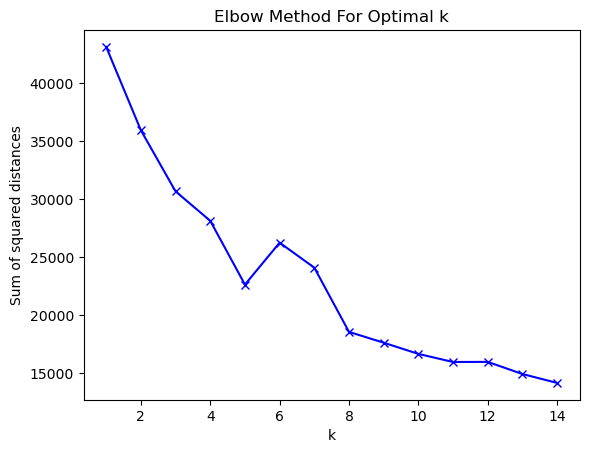

In [12]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

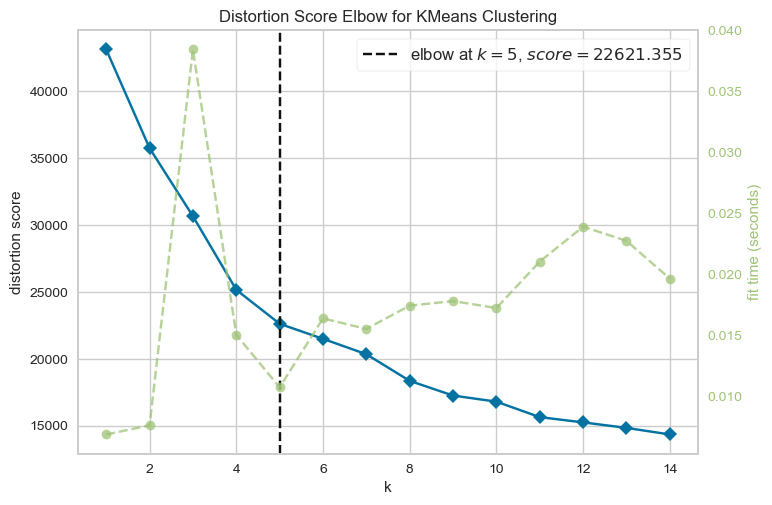

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(1,15))
 
visualizer.fit(scaled_df)
visualizer.show()

In [14]:
optimal_clusters = visualizer.elbow_value_

In [15]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000)
tsne_results = tsne.fit_transform(scaled_df)

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.algorithm = "lloyd"
kmeans.fit(tsne_results)
labels = kmeans.labels_

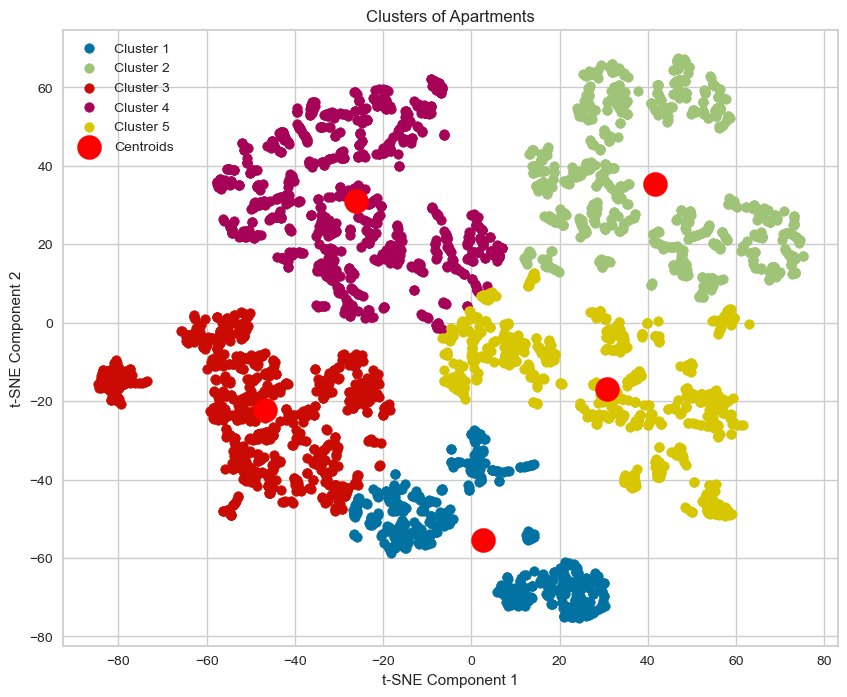

In [16]:
plt.figure(figsize=(10, 8))
for i in range(optimal_clusters):
    plt.scatter(tsne_results[labels == i, 0], tsne_results[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('Clusters of Apartments')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

In [17]:
with open("for_sale_clustering_model.pkl", "wb") as f:
    pickle.dump({"tsne":tsne,"kmeans":kmeans}, f)

### Testing Prediction For New Apartment

In [18]:
first_apartment_id = df.iloc[200].id
first_apartment = df[df.id == first_apartment_id]

In [19]:
first_apartment

,id,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
200,hUSNb2bsont,5,4,6500000,130,1.0,3.0,2.0,1.0,1.0,1.0,1.0


In [20]:
scaled_apartment = scaler.transform(first_apartment)

In [21]:
combined_data = np.vstack([scaled_df, scaled_apartment])
tsne_combined = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_combined_results = tsne_combined.fit_transform(combined_data)

# Extract the t-SNE results for the original data and the new item
tsne_results = tsne_combined_results[:-1]
new_item_tsne = tsne_combined_results[-1]

In [22]:
kmeans.fit(tsne_results)
labels = kmeans.labels_

In [23]:
new_item_label = kmeans.predict(new_item_tsne.reshape(1, -1))

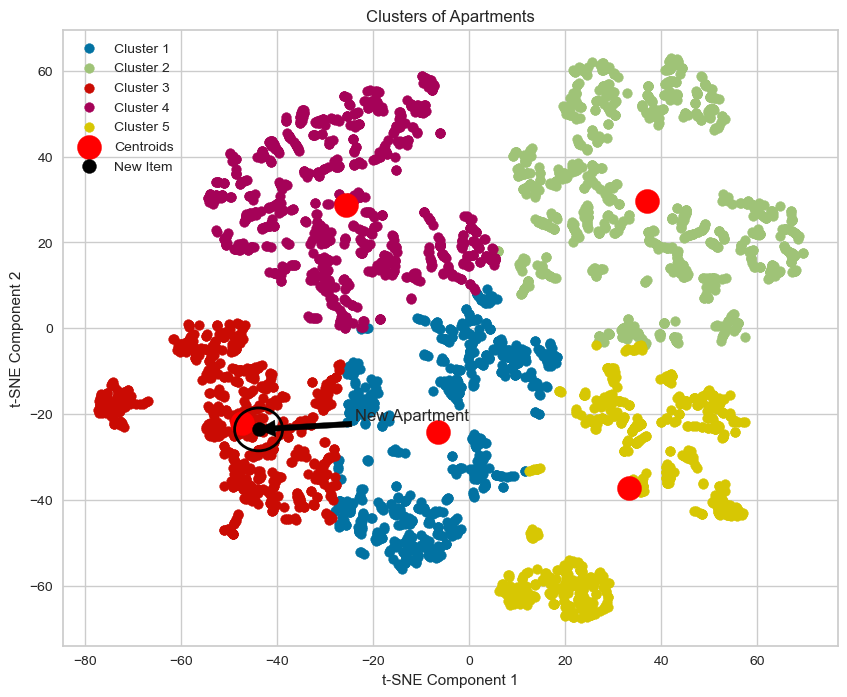

In [24]:
plt.figure(figsize=(10, 8))
for i in range(optimal_clusters):
    plt.scatter(tsne_results[labels == i, 0], tsne_results[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')

# Add the new item to the scatter plot
plt.scatter(new_item_tsne[0], new_item_tsne[1], s=100, c='black', label='New Item')

# Draw a circle around the new item
circle = plt.Circle((new_item_tsne[0], new_item_tsne[1]), 5, color='black', fill=False, linewidth=2)
plt.gca().add_artist(circle)

# Add an arrow pointing to the new item with text
plt.annotate('New Apartment', xy=(new_item_tsne[0], new_item_tsne[1]), xytext=(new_item_tsne[0] + 20, new_item_tsne[1] + 2),
             arrowprops=dict(facecolor='black', shrink=5))

plt.title('Clusters of Apartments')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()